Why does gradient represent distribution?

Calculate the gradient distribution before and after editing

In [2]:
from re import template
import tokenize
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
from utils.all_imports import *
from utils.data_processing_utils import *
from knowledge_distribution_NLL import each_layer_cosine, plot_cosine_NLL
from negation_curse_accuracy import negation_curse
# from simplified_sentence import simplified_sentence
model_device = 2
torch.cuda.set_device(model_device)
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,model_device)
hparams = ROMEHyperParams.from_name('llama-7b')
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)  
# load test data
with open("/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json","r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
edited_data,edited_sentence,edited_sentence_answer = make_edited_data(test_data[0])
model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)

Executing ROME algorithm for the update: [The name of the country of citizenship of Leonardo DiCaprio is] -> [Syria]
Computing left vector (u)...
Selected u projection object Leonardo DiCaprio
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -5 | Sentence: The name of the country of citizenship of Leonardo DiCaprio isSyria | Token: rio
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
Delta norm: 15.617
Change in target norm: 3.904 to 16.066 => 12.162
Division Factor: 3.215
Right vector norm: 4.858
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['model.layers.5.mlp.down_proj.weight']
Time elapsed: 6.98 seconds
New weights successfully inserted into ['model.layers.5.mlp.down_proj.weight']


In [3]:
context = test_data[0]['compositional_I_problems'][0]['compositional_query']['prompt']+" "
context

tensor(2.3431, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(3.4610, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(9.8871, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(3.2519, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(0.7596, device='cuda:2', grad_fn=<NllLossBackward0>)


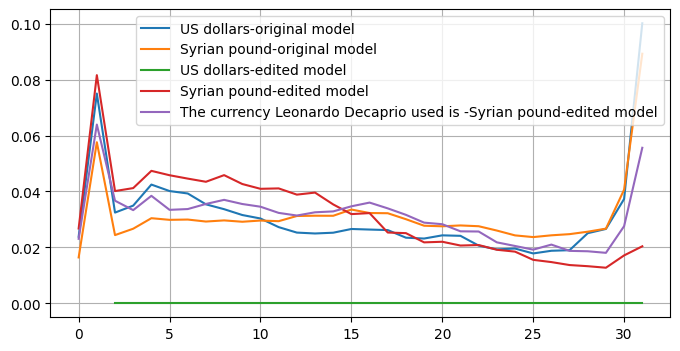

In [4]:
x = [i for i in range(32)]
plt.figure(figsize=(8,4))

context = test_data[0]['compositional_I_problems'][0]['compositional_query']['prompt']+" "

target = "US dollars"
model_gradients,loss = calculate_gradient(model,tokenizer,context + target,target,plot=False)
L1_1 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_1 = [x/sum(L1_1) for x in L1_1]
plt.plot(x, L1_standard_1, linestyle='-',label=f"{target}-original model")

target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model,tokenizer,context + target,target,plot=False)
L1_2 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_2 = [x/sum(L1_2) for x in L1_2]
plt.plot(x, L1_standard_2, linestyle='-',label=f"{target}-original model") 

target = "US dollars"
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_3 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_3 = [x/sum(L1_3) for x in L1_3]
plt.plot(x, L1_standard_3, linestyle='-',label=f"{target}-edited model") 

target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_4 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_4 = [x/sum(L1_4) for x in L1_4]
plt.plot(x, L1_standard_4, linestyle='-',label=f"{target}-edited model") 

context = "The currency Leonardo Decaprio use is "
target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_4 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_4 = [x/sum(L1_4) for x in L1_4]
plt.plot(x, L1_standard_4, linestyle='-',label=f"{context}-{target}-edited model") 

plt.legend()
plt.grid()
# plt.title(f"{context}-original model") 
plt.show()

In [25]:
import numpy as np
from scipy.stats import entropy
KL_divergence = entropy(np.array(L1_standard_2), np.array(L1_standard_4))
print(KL_divergence)

0.13575929029572237


In [7]:
test_data[0]['compositional_I_problems'][0]['compositional_query']['prompt']

'The name of the currency in the country of citizenship of Leonardo DiCaprio is'

tensor(3.2519, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(0.5011, device='cuda:2', grad_fn=<NllLossBackward0>)
tensor(3.3518, device='cuda:2', grad_fn=<NllLossBackward0>)


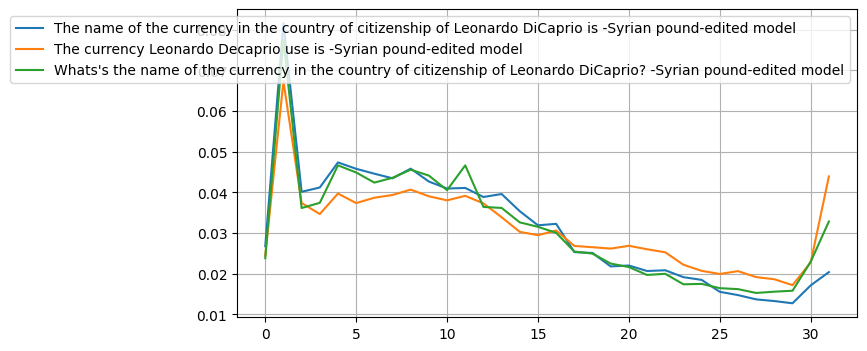

In [9]:
x = [i for i in range(32)]
plt.figure(figsize=(8,4))

context = test_data[0]['compositional_I_problems'][0]['compositional_query']['prompt']+" "


target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_4 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_4 = [x/sum(L1_4) for x in L1_4]
plt.plot(x, L1_standard_4, linestyle='-',label=f"{context}-{target}-edited model") 

context = "The currency Leonardo Decaprio use is "
target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_4 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_4 = [x/sum(L1_4) for x in L1_4]
plt.plot(x, L1_standard_4, linestyle='-',label=f"{context}-{target}-edited model") 

context = "Whats's the name of the currency in the country of citizenship of Leonardo DiCaprio? "
target = test_data[0]['compositional_I_problems'][0]['compositional_query']['answer']
model_gradients,loss = calculate_gradient(model_edited,tokenizer,context + target,target,plot=False)
L1_4 = [model_gradients[param].norm(p=1).item() for param in model_gradients if "down_proj" in param]
L1_standard_4 = [x/sum(L1_4) for x in L1_4]
plt.plot(x, L1_standard_4, linestyle='-',label=f"{context}-{target}-edited model") 

plt.legend()
plt.grid()
# plt.title(f"{context}-original model") 
plt.show()